# IMPORTS

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## LEITURA DOS DADOS

In [69]:
df = pd.read_csv('../RawData/train_radiomics_hipocamp.csv') 
df_test = pd.read_csv('../RawData/test_radiomics_hipocamp.csv')

print(f"Shape of df: {df.shape}")
print(f"Shape of df_test: {df_test.shape}")


Shape of df: (305, 2181)
Shape of df_test: (100, 2180)


# Tratamento

### Single Value Colums 

In [70]:
df = df.loc[:, df.nunique() > 1]
df_test = df_test.loc[:, df_test.nunique() > 1]


#  Analise das colunas que tem menos de 50 valores unicos 
n = df.nunique()
for col, e in n.items():
    if e < 50:  
        print(f"Coluna: {col}, Valores Unicos : {e}")



Coluna: original_firstorder_10Percentile, Valores Unicos : 31
Coluna: original_firstorder_90Percentile, Valores Unicos : 13
Coluna: original_firstorder_InterquartileRange, Valores Unicos : 13
Coluna: original_firstorder_Maximum, Valores Unicos : 29
Coluna: original_firstorder_Median, Valores Unicos : 15
Coluna: original_firstorder_Minimum, Valores Unicos : 30
Coluna: original_firstorder_Range, Valores Unicos : 45
Coluna: wavelet-HHH_glszm_GrayLevelNonUniformityNormalized, Valores Unicos : 33
Coluna: wavelet-HHH_glszm_GrayLevelVariance, Valores Unicos : 34
Coluna: gradient_firstorder_Minimum, Valores Unicos : 3
Coluna: lbp-2D_firstorder_10Percentile, Valores Unicos : 4
Coluna: lbp-2D_firstorder_90Percentile, Valores Unicos : 2
Coluna: lbp-2D_firstorder_InterquartileRange, Valores Unicos : 3
Coluna: lbp-2D_firstorder_Median, Valores Unicos : 2
Coluna: lbp-3D-m1_firstorder_10Percentile, Valores Unicos : 10
Coluna: lbp-3D-m1_firstorder_90Percentile, Valores Unicos : 12
Coluna: lbp-3D-m1_fi

### AGE BINING  ( secalhar isto era no 2 )

In [71]:

age_bins = [0, 65, 75, 85, 100]
# BINS_SIZER = ['<65', '65-74', '75-84', '85+']
age_labels = [60, 70, 80, 90] # VALOR MEDIO DO BIN 
df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels).astype(int)
df_test['Age'] = pd.cut(df_test['Age'], bins=age_bins, labels=age_labels).astype(int)



### Colunas Categoricas 

In [72]:
# Analisar a contagem de valores únicos para cada coluna categórica

# Identificar as colunas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"\nColuna: {col}")

#colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash'] 

colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'] 

# ** Bounding Box
#
# ** as colunas do 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'
# ** Deveriam ser retiradas, mas o bounding box pode ser importante para a zona de maior ativação do Alzimeir 
# **  ja a de centro de maxima devem ser muito correlacionados, por isso devem ser retirados mais para a frente 
# *TODO acabei por retirar para correr melhor os modelos, mas analisar se se deve retirar ou nao 

df.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)
df_test.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)


Coluna: ID

Coluna: Image

Coluna: Mask

Coluna: diagnostics_Image-original_Hash

Coluna: diagnostics_Mask-original_Hash

Coluna: diagnostics_Mask-original_BoundingBox

Coluna: diagnostics_Mask-original_CenterOfMassIndex

Coluna: diagnostics_Mask-original_CenterOfMass

Coluna: Transition


### Eliminar Transition CN-MCI && Label_Mapping

Como este tipo de precisao não vai ser realiza, decidimos retirar todas as linhas com ela relacinadas para nao confundir o nosso modelo

In [73]:
df = df[df['Transition'] != 'CN-MCI']


label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
#    'CN-MCI' : 4
}
# Apply the mapping to the target column
df['Transition'] = df['Transition'].map(label_mapping)


## Correlacao com target 

In [74]:
def remove_highly_correlated_with_target(data, target_column, threshold):
    # Compute the correlation of each column with the target column
    corr_with_target = data.corr()[target_column].abs()
    
    # Identify columns to remove based on correlation with the target
    to_drop = corr_with_target[corr_with_target >= threshold].index
    to_drop = to_drop.drop(target_column)  # Remove target column itself if included
    
    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final
print(df.shape)
df = remove_highly_correlated_with_target(df, 'Transition',threshold=0.16)
print(df.shape)


(295, 2014)
(295, 1521)


## Desvio Padrao 

In [75]:
from sklearn.feature_selection import VarianceThreshold


def remove_low_variance_features(data, threshold=0.01):
    # Remove low variance features
    selector = VarianceThreshold(threshold=threshold)
    low_variance_data = selector.fit_transform(data.select_dtypes(include=['float64', 'int64']))

    # Get the columns to keep
    retained_columns = data.select_dtypes(include=['float64', 'int64']).columns[selector.get_support(indices=True)]

    # Create a DataFrame with the retained columns
    data_reduced = pd.DataFrame(low_variance_data, columns=retained_columns)

    return data_reduced
print(df.shape)
#df = remove_low_variance_features(df)
print(df.shape)


(295, 1521)
(295, 1521)


## Correlacao colunas

In [76]:
def remove_highly_correlated_features(data, threshold=0.9):
    # Compute the correlation matrix
    corr_matrix = data.corr().abs()

    # Identify columns to remove based on correlation
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                to_drop.add(corr_matrix.columns[j])

    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final

## Models

In [77]:

#experiment = setup(df, target='Transition')

In [78]:
#best = compare_models()

Com o tratamento atual, o pycaret diz que os melhores modelos são :
- Random Forest Classifier
- Extra Trees Classifier
- Gradient Boosting Classifier 
- K Neighbors Classifier
- Extreme Gradient Boosting 


### Aplicação dos modelos (default) ao dataset tratado

In [79]:
from imblearn.over_sampling import SMOTE


In [80]:
#X = df.drop('Transition', axis=1)
#y = df['Transition']
#print(X.shape)
#print(y.shape)
#
#smote = SMOTE(sampling_strategy="auto", random_state=34)
#X_res, y_res = smote.fit_resample(X, y)
#print('Resampled dataset shape %s %s' % X_res.shape,y_res.shape)
#print("Y Smote Values:")
#y_res.value_counts()

In [81]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separar as features e o target
X = df.drop('Transition', axis=1)
y = df['Transition']

# Exibir as primeiras linhas e a forma de X
print("X:")
print(X.head())
print("X Shape:", X.shape)

# Dividir o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)


# Exibir a forma do conjunto de teste
print("X_test shape:", X_test.shape)

# Aplicar o SMOTE no conjunto de treino
smote = SMOTE(sampling_strategy="auto", random_state=34)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Exibir as formas dos conjuntos de dados após o SMOTE
print("Resampled dataset shape:", X_res.shape, y_res.shape)

# Exibir a contagem de amostras por classe após o SMOTE
print("Y Smote Values:")
print(y_res.value_counts())

# Inicializar dicionário para armazenar as pontuações de cross-validation do modelo
model_cross_score = {}


X:
   diagnostics_Image-original_Mean  diagnostics_Image-original_Maximum  \
0                         5.848123                                 178   
1                         5.238834                                 190   
2                         6.816667                                 155   
4                         5.568269                                 150   
5                         5.359231                                 157   

   original_shape_Elongation  original_shape_Flatness  \
0                   0.420040                 0.106547   
1                   0.425482                 0.102532   
2                   0.447685                 0.135582   
4                   0.411851                 0.080719   
5                   0.421088                 0.107766   

   original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                       10.757474                      100.964915   
1                       10.432362                      101.747321   
2 

In [82]:
print("Y Train Values:")
y_train.value_counts()

print("Y Res Values")
y_res.value_counts()

Y Train Values:
Y Res Values


Transition
3    72
0    72
1    72
2    72
Name: count, dtype: int64

### SMOTE

In [83]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

#### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.57      0.71      0.63        24
           1       0.61      0.73      0.67        15
           2       0.23      0.18      0.20        17
           3       0.46      0.33      0.39        18

    accuracy                           0.50        74
   macro avg       0.47      0.49      0.47        74
weighted avg       0.47      0.50      0.48        74



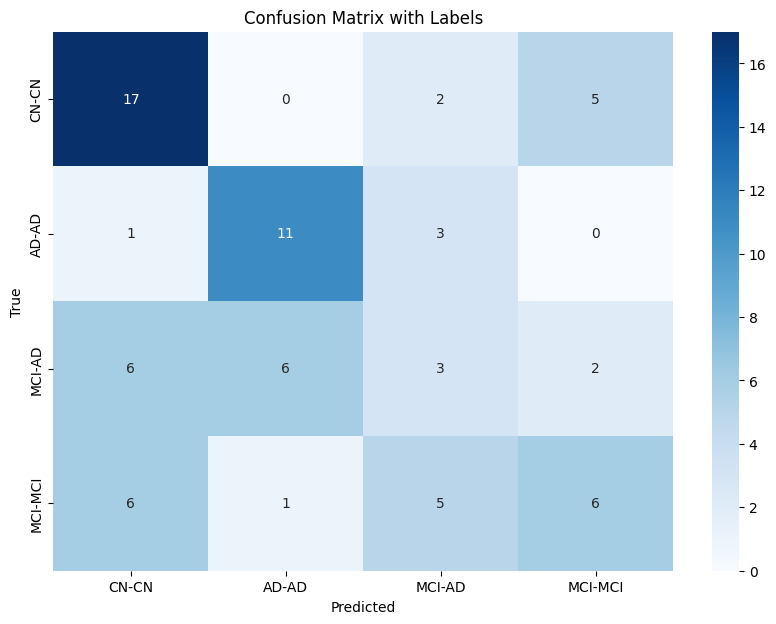

In [84]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)

rf_model.fit(X_res, y_res)


rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)

model_cross_score['random_forest'] = cross_val_score(rf_model, X_res, y_res, cv=5).mean()




#### Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.48      0.62      0.55        24
           1       0.41      0.47      0.44        15
           2       0.07      0.06      0.06        17
           3       0.36      0.22      0.28        18

    accuracy                           0.36        74
   macro avg       0.33      0.34      0.33        74
weighted avg       0.34      0.36      0.35        74



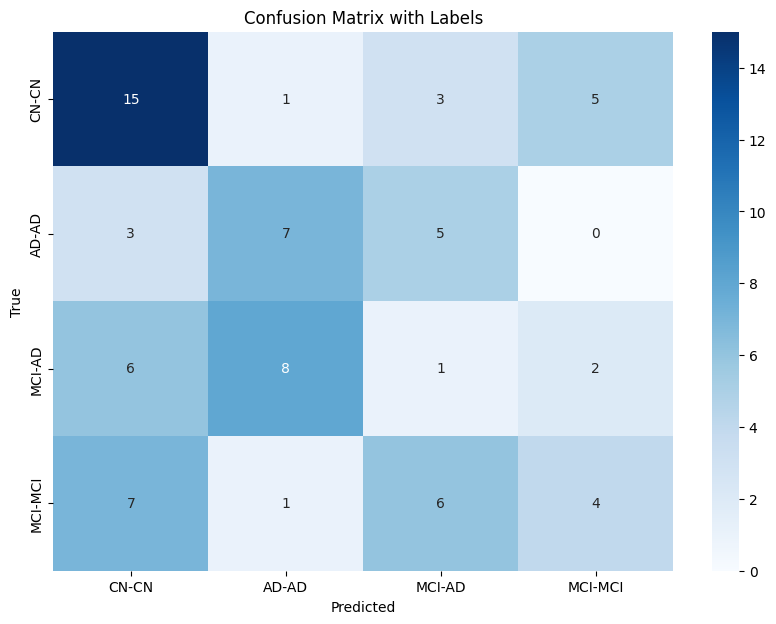

0.36486486486486486
0.6710223835450696


In [85]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)
et_model.fit(X_res, y_res)
et_pred = et_model.predict(X_test)
print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)
plt.show
print(accuracy_score(y_test, et_pred))
print(cross_val_score(et_model,X_res,y_res,cv=5).mean())

model_cross_score['Extra Trees'] = cross_val_score(et_model, X_res, y_res, cv=5).mean()


#### Gradient Boosting Classifier 

              precision    recall  f1-score   support

           0       0.55      0.67      0.60        24
           1       0.50      0.53      0.52        15
           2       0.33      0.24      0.28        17
           3       0.24      0.22      0.23        18

    accuracy                           0.43        74
   macro avg       0.41      0.41      0.41        74
weighted avg       0.41      0.43      0.42        74



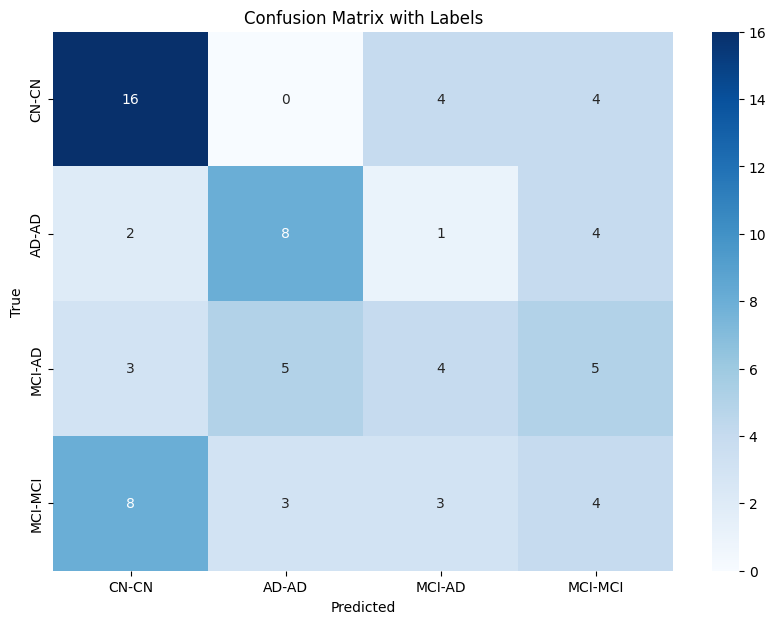

0.43243243243243246
0.6225650332728373


In [86]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)
gb_model.fit(X_res, y_res)
gb_pred = gb_model.predict(X_test)
print(classification_report(y_test,gb_pred))
cm = confusion_matrix(y_test,gb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, gb_pred))
score_cross = cross_val_score(gb_model,X_res,y_res,cv=5).mean()

print(score_cross)

model_cross_score['Gradient_boosting'] = score_cross


#### Extreme Gradient Boosting

              precision    recall  f1-score   support

           0       0.56      0.75      0.64        24
           1       0.58      0.47      0.52        15
           2       0.36      0.29      0.32        17
           3       0.31      0.28      0.29        18

    accuracy                           0.47        74
   macro avg       0.45      0.45      0.44        74
weighted avg       0.46      0.47      0.46        74



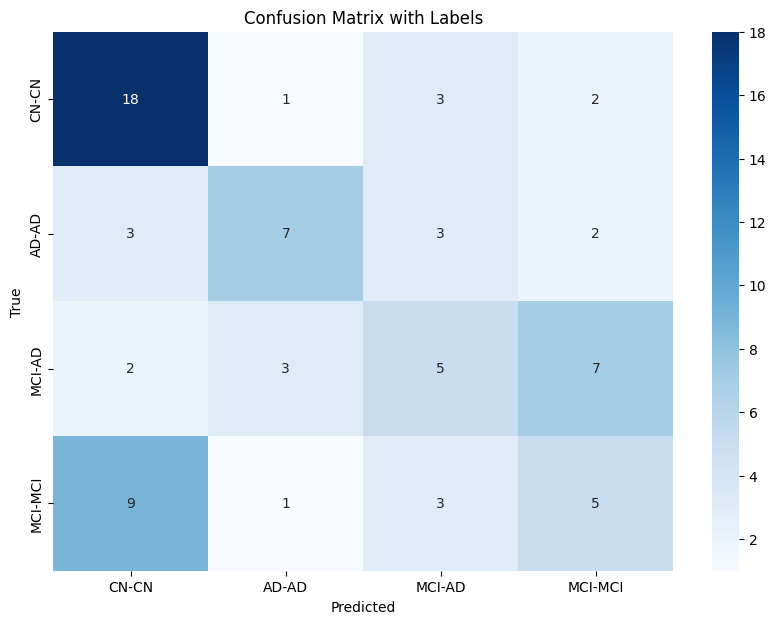

0.47297297297297297
0.6503932244404115


In [87]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)
xgb_model.fit(X_res, y_res)
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, xgb_pred))


score_cross = cross_val_score(xgb_model,X_res,y_res,cv=5).mean()

print(score_cross)

model_cross_score['XGBoost'] = score_cross

In [88]:

print("Numero de Colunas")
print(X_train.shape)
print("Numero de Colunas com Smote")
print(X_res.shape)


# função que compara os modelos, para isso, usa um dicionário {"Model Name: [predictions], ..."}
def compare_models(Y_test, predictions):
    # Create a dictionary of models and their respective accuracies
    model_accuracies = {}
    for name, prediction in predictions.items():
        # Calculate the accuracy for each model
        accuracy = sum(prediction == Y_test) / len(Y_test)
        # Add the model and its accuracy to the dictionary
        model_accuracies[name] = accuracy

    # Sort the models by their accuracy in ascending order
    sorted_models = sorted(model_accuracies, key=model_accuracies.get)

    # Print the table with the accuracy of each model
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model in sorted_models:
        print(model.ljust(20), str(model_accuracies[model]).rjust(10))


predictions = {
    'Random Forest Classifier' : rf_pred,
    'Extra Trees Classifier' : et_pred,
    'Gradient Boosting Classifier' : gb_pred,
    'Extreme Gradient Boosting' : xgb_pred
}

compare_models(y_test, predictions)


def compare_models_cross_score(model_cross_score):
    # Sort models by cross-validation score in descending order
    sorted_models = sorted(model_cross_score.items(), key=lambda x: x[1], reverse=True)

    # Print the table with the cross-validation score of each model
    print("Model".ljust(30), "Cross-Validation Score")
    print("-" * 45)
    for model, score in sorted_models:
        print(model.ljust(30), f"{score:.4f}".rjust(10))



compare_models_cross_score(model_cross_score)


Numero de Colunas
(221, 1520)
Numero de Colunas com Smote
(288, 1520)
Model                Accuracy
------------------------------
Extra Trees Classifier 0.36486486486486486
Gradient Boosting Classifier 0.43243243243243246
Extreme Gradient Boosting 0.47297297297297297
Random Forest Classifier        0.5
Model                          Cross-Validation Score
---------------------------------------------
Extra Trees                        0.6710
XGBoost                            0.6504
random_forest                      0.6327
Gradient_boosting                  0.6226
